<a href="https://colab.research.google.com/github/ishanki19-pixel/Recommendations_Using_GNN/blob/main/RECOMMENDATIONS_USING_GNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch_geometric torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.2.0+cpu.html


Looking in links: https://data.pyg.org/whl/torch-2.2.0+cpu.html


In [ ]:
!pip install pandas torch networkx matplotlib


In [ ]:
!pip install --upgrade pyg-lib -f https://data.pyg.org/whl/nightly/torch-2.2.0+cpu.html

Looking in links: https://data.pyg.org/whl/nightly/torch-2.2.0+cpu.html


In [ ]:
!pip install sentence-transformers

DEEP DIVING:





NEW IMPLEMENTATION


In [ ]:
from torch_geometric.data import download_url, extract_zip

url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
extract_zip(download_url(url, '.'), '.')

movies_path = './ml-latest-small/movies.csv'
ratings_path = './ml-latest-small/ratings.csv'

Using existing file ml-latest-small.zip
Extracting ./ml-latest-small.zip


In [ ]:
import pandas as pd

print('movies.csv:')
print(pd.read_csv(movies_path)[["movieId", "genres"]].head())
print()
print('ratings.csv:')
print(pd.read_csv(ratings_path)[["userId", "movieId"]].head())

movies.csv:
   movieId                                       genres
0        1  Adventure|Animation|Children|Comedy|Fantasy
1        2                   Adventure|Children|Fantasy
2        3                               Comedy|Romance
3        4                         Comedy|Drama|Romance
4        5                                       Comedy

ratings.csv:
   userId  movieId
0       1        1
1       1        3
2       1        6
3       1       47
4       1       50


In [ ]:
import torch
import pandas as pd

movies_df = pd.read_csv(movies_path, index_col='movieId')
genres = movies_df['genres'].str.get_dummies('|')
if '(no genres listed)' in genres.columns:
    genres.drop('(no genres listed)', axis=1, inplace=True)

print(genres[["Action", "Adventure", "Drama", "Horror"]].head())
Genres=list(genres.columns)
print(Genres)

movie_feat = torch.from_numpy(genres.values).to(torch.float)
print(movie_feat[9741])
assert movie_feat.size() == (9742, 19)  # 19 genres in total now.


         Action  Adventure  Drama  Horror
movieId                                  
1             0          1      0       0
2             0          1      0       0
3             0          0      0       0
4             0          0      1       0
5             0          0      0       0
['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


In [ ]:
ratings_df = pd.read_csv(ratings_path)

unique_user_id = ratings_df['userId'].unique()
unique_user_id = pd.DataFrame(data={
    'userId': unique_user_id,
    'mappedID': pd.RangeIndex(len(unique_user_id)),
})
print("Mapping of user IDs to consecutive values:")
print("==========================================")
print(unique_user_id.head())
print()

unique_movie_id = ratings_df['movieId'].unique()
unique_movie_id = pd.DataFrame(data={
    'movieId': movies_df.index,
    'mappedID': pd.RangeIndex(len(movies_df)),
})
print("Mapping of movie IDs to consecutive values:")
print("===========================================")
print(unique_movie_id.head())

ratings_user_id = pd.merge(ratings_df['userId'], unique_user_id,
                            left_on='userId', right_on='userId', how='left')
ratings_user_id = torch.from_numpy(ratings_user_id['mappedID'].values)
ratings_movie_id = pd.merge(ratings_df['movieId'], unique_movie_id,
                            left_on='movieId', right_on='movieId', how='left')
ratings_movie_id = torch.from_numpy(ratings_movie_id['mappedID'].values)
print(ratings_movie_id)
edge_index_user_to_movie = torch.stack([ratings_user_id, ratings_movie_id], dim=0)
assert edge_index_user_to_movie.size() == (2, 100836)

print()
print("Final edge indices pointing from users to movies:")
print("=================================================")
print(edge_index_user_to_movie)

Mapping of user IDs to consecutive values:
   userId  mappedID
0       1         0
1       2         1
2       3         2
3       4         3
4       5         4

Mapping of movie IDs to consecutive values:
   movieId  mappedID
0        1         0
1        2         1
2        3         2
3        4         3
4        5         4
tensor([   0,    2,    5,  ..., 9462, 9463, 9503])

Final edge indices pointing from users to movies:
tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    2,    5,  ..., 9462, 9463, 9503]])


In [ ]:
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

data = HeteroData()
data["user"].node_id = torch.arange(len(unique_user_id))
data["movie"].node_id = torch.arange(len(movies_df))

data["movie"].x = movie_feat
data["user", "rates", "movie"].edge_index = edge_index_user_to_movie

data = T.ToUndirected()(data)

print(data)

assert data.node_types == ["user", "movie"]
assert data.edge_types == [("user", "rates", "movie"),
                           ("movie", "rev_rates", "user")]
assert data["user"].num_nodes == 610
assert data["user"].num_features == 0
assert data["movie"].num_nodes == 9742
assert data["movie"].num_features == 19
assert data["user", "rates", "movie"].num_edges == 100836
assert data["movie", "rev_rates", "user"].num_edges == 100836

HeteroData(
  user={ node_id=[610] },
  movie={
    node_id=[9742],
    x=[9742, 19],
  },
  (user, rates, movie)={ edge_index=[2, 100836] },
  (movie, rev_rates, user)={ edge_index=[2, 100836] }
)


In [ ]:

# training (80%), validation (10%), and testing edges (10%).
# Across the training edges, 70% of edges for message passing,
# and 30% of edges for supervision.
# fixed negative edges for evaluation with a ratio of 2:1.
# Negative edges during training will be generated on-the-fly.
transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=2.0,
    add_negative_train_samples=False,
    edge_types=("user", "rates", "movie"),
    rev_edge_types=("movie", "rev_rates", "user"),
)

train_data, val_data, test_data = transform(data)
print("Training data:")
print("==============")
print(train_data)
print()
print("Validation data:")
print("================")
print(val_data)
print("Test data:")
print("================")
print(test_data)

assert train_data["user", "rates", "movie"].num_edges == 56469
assert train_data["user", "rates", "movie"].edge_label_index.size(1) == 24201
assert train_data["movie", "rev_rates", "user"].num_edges == 56469
# No negative edges added:
assert train_data["user", "rates", "movie"].edge_label.min() == 1
assert train_data["user", "rates", "movie"].edge_label.max() == 1

assert val_data["user", "rates", "movie"].num_edges == 80670
assert val_data["user", "rates", "movie"].edge_label_index.size(1) == 30249
assert val_data["movie", "rev_rates", "user"].num_edges == 80670
# Negative edges with ratio 2:1:
assert val_data["user", "rates", "movie"].edge_label.long().bincount().tolist() == [20166, 10083]

Training data:
HeteroData(
  user={ node_id=[610] },
  movie={
    node_id=[9742],
    x=[9742, 19],
  },
  (user, rates, movie)={
    edge_index=[2, 56469],
    edge_label=[24201],
    edge_label_index=[2, 24201],
  },
  (movie, rev_rates, user)={ edge_index=[2, 56469] }
)

Validation data:
HeteroData(
  user={ node_id=[610] },
  movie={
    node_id=[9742],
    x=[9742, 19],
  },
  (user, rates, movie)={
    edge_index=[2, 80670],
    edge_label=[30249],
    edge_label_index=[2, 30249],
  },
  (movie, rev_rates, user)={ edge_index=[2, 80670] }
)
Test data:
HeteroData(
  user={ node_id=[610] },
  movie={
    node_id=[9742],
    x=[9742, 19],
  },
  (user, rates, movie)={
    edge_index=[2, 90753],
    edge_label=[30249],
    edge_label_index=[2, 30249],
  },
  (movie, rev_rates, user)={ edge_index=[2, 90753] }
)


In [ ]:
# In the first hop, we sample at most 20 neighbors.
# In the second hop, we sample at most 10 neighbors.
# In addition, during training, we want to sample negative edges on-the-fly with
# a ratio of 2:1.
# We can make use of the `loader.LinkNeighborLoader` from PyG:
from torch_geometric.loader import LinkNeighborLoader

# Define seed edges:
edge_label_index = train_data["user", "rates", "movie"].edge_label_index
edge_label = train_data["user", "rates", "movie"].edge_label

train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[20, 10],
    neg_sampling_ratio=2.0,
    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=True,
)


In [ ]:
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

class Classifier(torch.nn.Module):
    def forward(self, x_user, x_movie, edge_label_index):
        # Convert node embeddings to edge-level representations:
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_movie = x_movie[edge_label_index[1]]

        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_user * edge_feat_movie).sum(dim=-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

        self.movie_lin = torch.nn.Linear(19, hidden_channels)
        self.user_emb = torch.nn.Embedding(data["user"].num_nodes, hidden_channels)
        self.movie_emb = torch.nn.Embedding(data["movie"].num_nodes, hidden_channels)


        self.gnn = GNN(hidden_channels)

        # Convert GNN model into a heterogeneous variant:
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())

        self.classifier = Classifier()

    def forward(self, data: HeteroData):
        x_dict = {
          "user": self.user_emb(data["user"].node_id),
          "movie": self.movie_lin(data["movie"].x) + self.movie_emb(data["movie"].node_id),
        }

        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict["user"],
            x_dict["movie"],
            data["user", "rates", "movie"].edge_label_index,
        )

        return pred


model = Model(hidden_channels=64)

print(model)


Model(
  (movie_lin): Linear(in_features=19, out_features=64, bias=True)
  (user_emb): Embedding(610, 64)
  (movie_emb): Embedding(9742, 64)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (user__rates__movie): SAGEConv(64, 64, aggr=mean)
      (movie__rev_rates__user): SAGEConv(64, 64, aggr=mean)
    )
    (conv2): ModuleDict(
      (user__rates__movie): SAGEConv(64, 64, aggr=mean)
      (movie__rev_rates__user): SAGEConv(64, 64, aggr=mean)
    )
  )
  (classifier): Classifier()
)


Device: 'cpu'


100%|██████████| 190/190 [00:07<00:00, 24.19it/s]


Epoch: 001, Loss: 0.4415, Precision: 0.6951, Recall: 0.6157, MAP: 0.7199


100%|██████████| 190/190 [00:07<00:00, 27.08it/s]


Epoch: 002, Loss: 0.3479, Precision: 0.7725, Recall: 0.7681, MAP: 0.8268


100%|██████████| 190/190 [00:07<00:00, 23.97it/s]


Epoch: 003, Loss: 0.3291, Precision: 0.7784, Recall: 0.7899, MAP: 0.8400


100%|██████████| 190/190 [00:07<00:00, 24.86it/s]


Epoch: 004, Loss: 0.3118, Precision: 0.7920, Recall: 0.8065, MAP: 0.8531


100%|██████████| 190/190 [00:07<00:00, 24.60it/s]


Epoch: 005, Loss: 0.3004, Precision: 0.7997, Recall: 0.8119, MAP: 0.8600


100%|██████████| 190/190 [00:06<00:00, 27.40it/s]


Epoch: 006, Loss: 0.2867, Precision: 0.8073, Recall: 0.8244, MAP: 0.8705


100%|██████████| 190/190 [00:07<00:00, 24.54it/s]


Epoch: 007, Loss: 0.2759, Precision: 0.8141, Recall: 0.8351, MAP: 0.8786


100%|██████████| 190/190 [00:08<00:00, 22.29it/s]


Epoch: 008, Loss: 0.2688, Precision: 0.8183, Recall: 0.8404, MAP: 0.8807


100%|██████████| 190/190 [00:06<00:00, 27.63it/s]


Epoch: 009, Loss: 0.2585, Precision: 0.8234, Recall: 0.8475, MAP: 0.8886


100%|██████████| 190/190 [00:07<00:00, 24.15it/s]


Epoch: 010, Loss: 0.2543, Precision: 0.8257, Recall: 0.8504, MAP: 0.8877


100%|██████████| 190/190 [00:06<00:00, 28.03it/s]


Epoch: 011, Loss: 0.2514, Precision: 0.8284, Recall: 0.8568, MAP: 0.8893


100%|██████████| 190/190 [00:07<00:00, 24.51it/s]


Epoch: 012, Loss: 0.2372, Precision: 0.8360, Recall: 0.8662, MAP: 0.8988


100%|██████████| 190/190 [00:06<00:00, 27.60it/s]


Epoch: 013, Loss: 0.2341, Precision: 0.8386, Recall: 0.8706, MAP: 0.8998


100%|██████████| 190/190 [00:07<00:00, 24.42it/s]


Epoch: 014, Loss: 0.2295, Precision: 0.8401, Recall: 0.8759, MAP: 0.9008


100%|██████████| 190/190 [00:07<00:00, 25.86it/s]


Epoch: 015, Loss: 0.2258, Precision: 0.8422, Recall: 0.8823, MAP: 0.9018


100%|██████████| 190/190 [00:07<00:00, 25.76it/s]


Epoch: 016, Loss: 0.2191, Precision: 0.8469, Recall: 0.8876, MAP: 0.9072


100%|██████████| 190/190 [00:07<00:00, 24.51it/s]


Epoch: 017, Loss: 0.2145, Precision: 0.8503, Recall: 0.8902, MAP: 0.9073


100%|██████████| 190/190 [00:06<00:00, 27.37it/s]


Epoch: 018, Loss: 0.2086, Precision: 0.8562, Recall: 0.8991, MAP: 0.9118


100%|██████████| 190/190 [00:07<00:00, 24.40it/s]


Epoch: 019, Loss: 0.2067, Precision: 0.8570, Recall: 0.8995, MAP: 0.9114


100%|██████████| 190/190 [00:06<00:00, 27.82it/s]


Epoch: 020, Loss: 0.2033, Precision: 0.8591, Recall: 0.9056, MAP: 0.9128


100%|██████████| 190/190 [00:07<00:00, 24.35it/s]


Epoch: 021, Loss: 0.1981, Precision: 0.8619, Recall: 0.9065, MAP: 0.9149


100%|██████████| 190/190 [00:06<00:00, 27.92it/s]


Epoch: 022, Loss: 0.1934, Precision: 0.8655, Recall: 0.9146, MAP: 0.9187


100%|██████████| 190/190 [00:07<00:00, 24.13it/s]


Epoch: 023, Loss: 0.1913, Precision: 0.8660, Recall: 0.9168, MAP: 0.9168


100%|██████████| 190/190 [00:07<00:00, 26.22it/s]


Epoch: 024, Loss: 0.1853, Precision: 0.8701, Recall: 0.9215, MAP: 0.9222


100%|██████████| 190/190 [00:07<00:00, 25.26it/s]


Epoch: 025, Loss: 0.1844, Precision: 0.8711, Recall: 0.9255, MAP: 0.9212


100%|██████████| 190/190 [00:07<00:00, 24.38it/s]


Epoch: 026, Loss: 0.1814, Precision: 0.8745, Recall: 0.9287, MAP: 0.9230


100%|██████████| 190/190 [00:07<00:00, 23.78it/s]


Epoch: 027, Loss: 0.1783, Precision: 0.8752, Recall: 0.9309, MAP: 0.9241


100%|██████████| 190/190 [00:07<00:00, 24.46it/s]


Epoch: 028, Loss: 0.1768, Precision: 0.8767, Recall: 0.9361, MAP: 0.9245


100%|██████████| 190/190 [00:06<00:00, 27.66it/s]


Epoch: 029, Loss: 0.1715, Precision: 0.8807, Recall: 0.9393, MAP: 0.9275


100%|██████████| 190/190 [00:07<00:00, 24.00it/s]


Epoch: 030, Loss: 0.1686, Precision: 0.8822, Recall: 0.9425, MAP: 0.9283


100%|██████████| 190/190 [00:06<00:00, 27.25it/s]


Epoch: 031, Loss: 0.1686, Precision: 0.8829, Recall: 0.9442, MAP: 0.9278


100%|██████████| 190/190 [00:07<00:00, 25.18it/s]


Epoch: 032, Loss: 0.1700, Precision: 0.8800, Recall: 0.9430, MAP: 0.9269


100%|██████████| 190/190 [00:07<00:00, 24.55it/s]


Epoch: 033, Loss: 0.1628, Precision: 0.8866, Recall: 0.9483, MAP: 0.9318


100%|██████████| 190/190 [00:08<00:00, 21.55it/s]


Epoch: 034, Loss: 0.1617, Precision: 0.8876, Recall: 0.9502, MAP: 0.9307


100%|██████████| 190/190 [00:07<00:00, 24.00it/s]


Epoch: 035, Loss: 0.1590, Precision: 0.8899, Recall: 0.9500, MAP: 0.9341


100%|██████████| 190/190 [00:06<00:00, 27.81it/s]


Epoch: 036, Loss: 0.1568, Precision: 0.8900, Recall: 0.9530, MAP: 0.9352


100%|██████████| 190/190 [00:07<00:00, 23.86it/s]


Epoch: 037, Loss: 0.1549, Precision: 0.8934, Recall: 0.9560, MAP: 0.9340


100%|██████████| 190/190 [00:07<00:00, 25.57it/s]


Epoch: 038, Loss: 0.1546, Precision: 0.8936, Recall: 0.9568, MAP: 0.9318


100%|██████████| 190/190 [00:07<00:00, 25.75it/s]


Epoch: 039, Loss: 0.1528, Precision: 0.8937, Recall: 0.9564, MAP: 0.9354


100%|██████████| 190/190 [00:07<00:00, 23.98it/s]


Epoch: 040, Loss: 0.1506, Precision: 0.8948, Recall: 0.9593, MAP: 0.9347


100%|██████████| 190/190 [00:06<00:00, 27.61it/s]


Epoch: 041, Loss: 0.1493, Precision: 0.8952, Recall: 0.9604, MAP: 0.9380


100%|██████████| 190/190 [00:07<00:00, 24.12it/s]


Epoch: 042, Loss: 0.1456, Precision: 0.8984, Recall: 0.9614, MAP: 0.9386


100%|██████████| 190/190 [00:06<00:00, 27.27it/s]


Epoch: 043, Loss: 0.1451, Precision: 0.8979, Recall: 0.9620, MAP: 0.9397


100%|██████████| 190/190 [00:07<00:00, 23.80it/s]


Epoch: 044, Loss: 0.1435, Precision: 0.9003, Recall: 0.9628, MAP: 0.9405


100%|██████████| 190/190 [00:07<00:00, 25.55it/s]


Epoch: 045, Loss: 0.1412, Precision: 0.9028, Recall: 0.9646, MAP: 0.9421


100%|██████████| 190/190 [00:07<00:00, 25.58it/s]


Epoch: 046, Loss: 0.1371, Precision: 0.9034, Recall: 0.9661, MAP: 0.9462


100%|██████████| 190/190 [00:07<00:00, 23.77it/s]


Epoch: 047, Loss: 0.1360, Precision: 0.9069, Recall: 0.9671, MAP: 0.9455


100%|██████████| 190/190 [00:06<00:00, 27.61it/s]


Epoch: 048, Loss: 0.1395, Precision: 0.9032, Recall: 0.9646, MAP: 0.9429


100%|██████████| 190/190 [00:08<00:00, 23.69it/s]


Epoch: 049, Loss: 0.1372, Precision: 0.9047, Recall: 0.9681, MAP: 0.9439


100%|██████████| 190/190 [00:08<00:00, 23.07it/s]


Epoch: 050, Loss: 0.1351, Precision: 0.9077, Recall: 0.9686, MAP: 0.9447


100%|██████████| 190/190 [00:07<00:00, 24.02it/s]


Epoch: 051, Loss: 0.1309, Precision: 0.9091, Recall: 0.9701, MAP: 0.9470


100%|██████████| 190/190 [00:07<00:00, 25.09it/s]


Epoch: 052, Loss: 0.1316, Precision: 0.9098, Recall: 0.9691, MAP: 0.9472


100%|██████████| 190/190 [00:07<00:00, 26.17it/s]


Epoch: 053, Loss: 0.1341, Precision: 0.9080, Recall: 0.9680, MAP: 0.9444


100%|██████████| 190/190 [00:08<00:00, 23.69it/s]


Epoch: 054, Loss: 0.1287, Precision: 0.9106, Recall: 0.9714, MAP: 0.9469


100%|██████████| 190/190 [00:06<00:00, 27.17it/s]


Epoch: 055, Loss: 0.1307, Precision: 0.9100, Recall: 0.9705, MAP: 0.9464


100%|██████████| 190/190 [00:07<00:00, 23.78it/s]


Epoch: 056, Loss: 0.1256, Precision: 0.9109, Recall: 0.9736, MAP: 0.9505


100%|██████████| 190/190 [00:06<00:00, 27.51it/s]


Epoch: 057, Loss: 0.1275, Precision: 0.9130, Recall: 0.9691, MAP: 0.9470


100%|██████████| 190/190 [00:07<00:00, 24.17it/s]


Epoch: 058, Loss: 0.1293, Precision: 0.9110, Recall: 0.9721, MAP: 0.9464


100%|██████████| 190/190 [00:07<00:00, 25.52it/s]


Epoch: 059, Loss: 0.1249, Precision: 0.9133, Recall: 0.9736, MAP: 0.9506


100%|██████████| 190/190 [00:07<00:00, 25.32it/s]


Epoch: 060, Loss: 0.1242, Precision: 0.9141, Recall: 0.9752, MAP: 0.9493


100%|██████████| 190/190 [00:07<00:00, 23.88it/s]


Epoch: 061, Loss: 0.1302, Precision: 0.9110, Recall: 0.9733, MAP: 0.9439


100%|██████████| 190/190 [00:06<00:00, 27.60it/s]


Epoch: 062, Loss: 0.1223, Precision: 0.9148, Recall: 0.9733, MAP: 0.9519


100%|██████████| 190/190 [00:07<00:00, 23.83it/s]


Epoch: 063, Loss: 0.1204, Precision: 0.9169, Recall: 0.9745, MAP: 0.9529


100%|██████████| 190/190 [00:07<00:00, 27.00it/s]


Epoch: 064, Loss: 0.1225, Precision: 0.9159, Recall: 0.9752, MAP: 0.9508


100%|██████████| 190/190 [00:08<00:00, 23.26it/s]


Epoch: 065, Loss: 0.1216, Precision: 0.9150, Recall: 0.9748, MAP: 0.9516


100%|██████████| 190/190 [00:07<00:00, 26.00it/s]


Epoch: 066, Loss: 0.1216, Precision: 0.9159, Recall: 0.9742, MAP: 0.9522


100%|██████████| 190/190 [00:07<00:00, 24.61it/s]


Epoch: 067, Loss: 0.1204, Precision: 0.9168, Recall: 0.9763, MAP: 0.9519


100%|██████████| 190/190 [00:07<00:00, 24.17it/s]


Epoch: 068, Loss: 0.1173, Precision: 0.9203, Recall: 0.9756, MAP: 0.9537


100%|██████████| 190/190 [00:07<00:00, 26.92it/s]


Epoch: 069, Loss: 0.1137, Precision: 0.9206, Recall: 0.9794, MAP: 0.9561


100%|██████████| 190/190 [00:07<00:00, 23.91it/s]


Epoch: 070, Loss: 0.1160, Precision: 0.9204, Recall: 0.9775, MAP: 0.9550


100%|██████████| 190/190 [00:06<00:00, 27.33it/s]


Epoch: 071, Loss: 0.1168, Precision: 0.9208, Recall: 0.9771, MAP: 0.9544


100%|██████████| 190/190 [00:07<00:00, 24.08it/s]


Epoch: 072, Loss: 0.1151, Precision: 0.9207, Recall: 0.9783, MAP: 0.9542


100%|██████████| 190/190 [00:08<00:00, 22.44it/s]


Epoch: 073, Loss: 0.1129, Precision: 0.9226, Recall: 0.9790, MAP: 0.9562


100%|██████████| 190/190 [00:07<00:00, 24.93it/s]


Epoch: 074, Loss: 0.1138, Precision: 0.9224, Recall: 0.9778, MAP: 0.9558


100%|██████████| 190/190 [00:07<00:00, 23.83it/s]


Epoch: 075, Loss: 0.1143, Precision: 0.9218, Recall: 0.9782, MAP: 0.9538


100%|██████████| 190/190 [00:06<00:00, 27.57it/s]


Epoch: 076, Loss: 0.1148, Precision: 0.9214, Recall: 0.9781, MAP: 0.9539


100%|██████████| 190/190 [00:07<00:00, 24.16it/s]


Epoch: 077, Loss: 0.1168, Precision: 0.9199, Recall: 0.9754, MAP: 0.9551


100%|██████████| 190/190 [00:06<00:00, 27.54it/s]


Epoch: 078, Loss: 0.1150, Precision: 0.9201, Recall: 0.9787, MAP: 0.9551
Early stopping at epoch 78, Best Loss: 0.1129


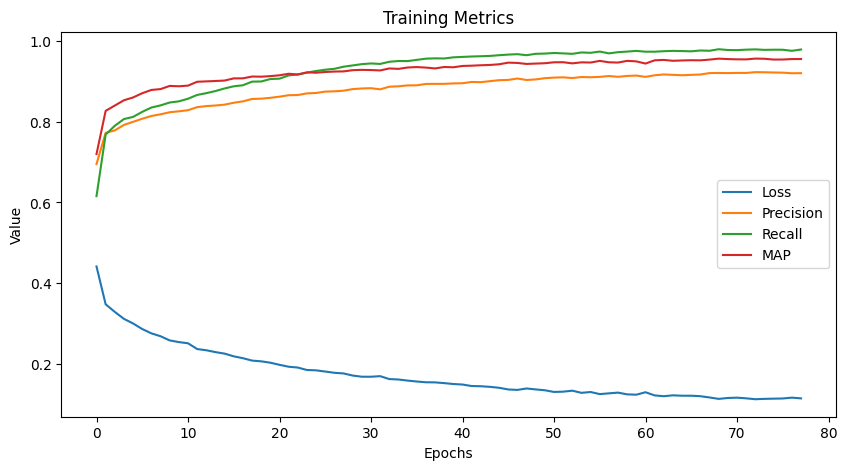

Number of epochs trained: 73


In [ ]:
import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100
patience = 5
best_loss = float('inf')
num_epochs = 0

losses = []
maps = []
precisions = []
recalls = []

for epoch in range(1, epochs + 1):
    total_loss = total_examples = 0
    total_precision = total_recall = total_map = 0

    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()

        sampled_data.to(device)
        pred = model(sampled_data)

        ground_truth = sampled_data["user", "rates", "movie"].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)

        loss.backward()
        optimizer.step()

        pred_labels = torch.sigmoid(pred) > 0.5
        batch_precision = (pred_labels * ground_truth).sum().item() / (pred_labels.sum().item() + 1e-9)
        batch_recall = (pred_labels * ground_truth).sum().item() / (ground_truth.sum().item() + 1e-9)
        batch_map = average_precision_score(ground_truth.detach().cpu().numpy(), torch.sigmoid(pred).detach().cpu().numpy())

        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
        total_precision += batch_precision
        total_recall += batch_recall
        total_map += batch_map

    avg_loss = total_loss / total_examples
    avg_precision = total_precision / len(train_loader)
    avg_recall = total_recall / len(train_loader)
    avg_map = total_map / len(train_loader)


    losses.append(avg_loss)
    precisions.append(avg_precision)
    recalls.append(avg_recall)
    maps.append(avg_map)

    print(f"Epoch: {epoch:03d}, Loss: {avg_loss:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, MAP: {avg_map:.4f}")

    # Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        num_epochs = epoch
    elif epoch - num_epochs >= patience:
        print(f"Early stopping at epoch {epoch}, Best Loss: {best_loss:.4f}")
        break

plt.figure(figsize=(10, 5))
plt.plot(losses, label='Loss')
plt.plot(precisions, label='Precision')
plt.plot(recalls, label='Recall')
plt.plot(maps, label='MAP')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Metrics')
plt.legend()
plt.show()

print(f"Number of epochs trained: {num_epochs}")


In [ ]:

edge_label_index = val_data["user", "rates", "movie"].edge_label_index
edge_label = val_data["user", "rates", "movie"].edge_label

val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 10],
    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * 128,
    shuffle=False,
)

sampled_data = next(iter(val_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)

assert sampled_data["user", "rates", "movie"].edge_label_index.size(1) == 3 * 128
assert sampled_data["user", "rates", "movie"].edge_label.min() >= 0
assert sampled_data["user", "rates", "movie"].edge_label.max() <= 1

Sampled mini-batch:
HeteroData(
  user={
    node_id=[609],
    n_id=[609],
    num_sampled_nodes=[3],
  },
  movie={
    node_id=[2726],
    x=[2726, 19],
    n_id=[2726],
    num_sampled_nodes=[3],
  },
  (user, rates, movie)={
    edge_index=[2, 19679],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[19679],
    num_sampled_edges=[2],
    input_id=[384],
  },
  (movie, rev_rates, user)={
    edge_index=[2, 7904],
    e_id=[7904],
    num_sampled_edges=[2],
  }
)


In [ ]:
from sklearn.metrics import roc_auc_score

preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data))
        ground_truths.append(sampled_data["user", "rates", "movie"].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
print()
print(f"Validation AUC: {auc:.4f}")

100%|██████████| 79/79 [00:01<00:00, 61.41it/s]


Validation AUC: 0.9170


In [ ]:

edge_label_index_test = test_data["user", "rates", "movie"].edge_label_index
edge_label_test = test_data["user", "rates", "movie"].edge_label

test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[20, 10],
    edge_label_index=(("user", "rates", "movie"), edge_label_index_test),
    edge_label=edge_label_test,
    batch_size=3 * 128,
    shuffle=False,
)

preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(test_loader):
    with torch.no_grad():
        sampled_data.to(device)
        pred = model(sampled_data)
        preds.append(pred)
        ground_truths.append(sampled_data["user", "rates", "movie"].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()

auc = roc_auc_score(ground_truth, pred)
print()
print(f"Testing AUC: {auc:.4f}")


100%|██████████| 79/79 [00:01<00:00, 62.13it/s]


Testing AUC: 0.9188


In [ ]:

def predict(model, user_id, movie_feat):
    model.eval()
    with torch.no_grad():
        user_emb = model.user_emb(torch.tensor(user_id).to(device))
        movie_emb = model.movie_lin(movie_feat) + model.movie_emb(torch.arange(len(movie_feat)).to(device))
        pred = torch.matmul(user_emb, movie_emb.T)
        pred = torch.sigmoid(pred) * 4 + 1  # Normalizing
    return pred.cpu().numpy()

user_id = 59
predictions = predict(model, user_id, movie_feat)
print(predictions)


[1.0001154 1.008685  4.8984833 ... 4.6759233 4.9999995 1.0000025]


In [ ]:
def predict(model, user_id, movie_feat):
    model.eval()
    with torch.no_grad():
        user_emb = model.user_emb(torch.tensor(user_id).to(device))
        movie_emb = model.movie_lin(movie_feat) + model.movie_emb(torch.arange(len(movie_feat)).to(device))
        pred = torch.matmul(user_emb, movie_emb.T)
        pred = torch.sigmoid(pred) * 4 + 1
    return pred.cpu().numpy()

user_id = 559
predictions = predict(model, user_id, movie_feat)
print(predictions)

[1.0095637 4.9999213 4.126358  ... 4.638569  4.612382  4.99994  ]


In [ ]:

def get_highly_rated_movies(predictions, threshold=4):
    highly_rated_movies = []
    for movie_id, rating in enumerate(predictions):
        if rating > threshold:
            highly_rated_movies.append(movie_id)
    return highly_rated_movies


highly_rated_movie_ids = get_highly_rated_movies(predictions)

print("Highly rated movie IDs (predicted ratings > 4):")
print(highly_rated_movie_ids)
print(len(highly_rated_movie_ids))


Highly rated movie IDs (predicted ratings > 4):
[1, 2, 5, 6, 9, 11, 12, 16, 19, 20, 21, 22, 23, 26, 28, 29, 30, 31, 32, 37, 38, 41, 42, 47, 49, 50, 53, 54, 56, 58, 59, 62, 65, 66, 69, 78, 80, 81, 82, 86, 88, 90, 91, 92, 94, 95, 96, 97, 98, 99, 100, 102, 103, 109, 110, 111, 112, 115, 116, 120, 121, 122, 123, 124, 128, 129, 130, 131, 132, 133, 134, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148, 153, 154, 156, 158, 159, 160, 161, 162, 166, 167, 172, 173, 175, 176, 178, 179, 182, 183, 188, 191, 192, 196, 197, 198, 200, 203, 206, 207, 211, 213, 215, 217, 219, 220, 223, 224, 225, 227, 229, 232, 233, 241, 242, 243, 246, 248, 249, 252, 254, 255, 257, 261, 263, 264, 267, 269, 271, 272, 273, 274, 275, 276, 277, 278, 279, 283, 286, 287, 289, 290, 291, 292, 293, 294, 297, 299, 302, 303, 304, 307, 311, 317, 320, 324, 325, 326, 328, 332, 333, 334, 336, 337, 338, 341, 344, 345, 346, 348, 349, 350, 352, 354, 355, 358, 360, 366, 367, 370, 371, 373, 376, 378, 379, 381, 384, 385, 388, 389, 3

In [ ]:
def predict_top_movies(model, user_id, movie_feats, user_ratings, movies_data):
    model.eval()
    with torch.no_grad():
        user_emb = model.user_emb(torch.tensor(user_id).to(device))
        movie_emb = model.movie_lin(movie_feats) + model.movie_emb(torch.arange(len(movie_feats)).to(device))
        preds = torch.matmul(user_emb, movie_emb.T)
        preds = torch.sigmoid(preds) * 4 + 1

        high_rating_indices = torch.nonzero(preds > 4).squeeze()

        user_prefs = user_ratings.groupby('userId').mean().drop(columns='movieId').loc[user_id]
        user_prefs_tensor = torch.tensor(user_prefs.values, dtype=torch.float).unsqueeze(0).to(device)
        relevant_movie_feats = movie_feats[:, :len(user_prefs)]

        high_rating_movie_feats = relevant_movie_feats[high_rating_indices]
        similarities = F.cosine_similarity(high_rating_movie_feats, user_prefs_tensor, dim=1)
        combined_scores = (preds[high_rating_indices] + similarities).flatten().cpu().numpy()

        sorted_indices = combined_scores.argsort()[::-1][:20]

        top_movies = []
        for idx in sorted_indices:
            movie_id = high_rating_indices[idx].item()
            if movie_id in movies_data.index:
                title = movies_data.loc[movie_id]['title']
                genres = movies_data.loc[movie_id]['genres']
                top_movies.append((movie_id, title, genres))

    return top_movies

user_id =559
top_movies = predict_top_movies(model, user_id, movie_feat, ratings_df, movies_df)
print("Top recommended movies for user {}: ".format(user_id))
for idx, (movie_id, title, genres) in enumerate(top_movies, start=1):
    print("{}. {} - {}".format(idx, title, genres))


Top recommended movies for user 559: 
1. Razor's Edge, The (1984) - Drama
2. Interstate 60 (2002) - Adventure|Comedy|Drama|Fantasy|Mystery|Sci-Fi|Thriller
3. Ladder 49 (2004) - Action|Drama|Thriller
4. Temptress Moon (Feng Yue) (1996) - Romance
5. Legend of Bagger Vance, The (2000) - Drama|Romance
6. Mystery Train (1989) - Comedy|Drama
7. Exterminating Angel, The (Ángel exterminador, El) (1962) - Comedy|Drama|Fantasy|Mystery
8. Player, The (1992) - Comedy|Crime|Drama
9. Steam: The Turkish Bath (Hamam) (1997) - Drama|Romance
10. Friends & Lovers (1999) - Comedy|Drama|Romance


In [ ]:
import torch
import pandas as pd
import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, roc_auc_score
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv, to_hetero
from torch_geometric.loader import LinkNeighborLoader

# Load data
url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
extract_zip(download_url(url, '.'), '.')

movies_path = './ml-latest-small/movies.csv'
ratings_path = './ml-latest-small/ratings.csv'
movies_df = pd.read_csv(movies_path, index_col='movieId')
ratings_df = pd.read_csv(ratings_path)

# Process data
genres = movies_df['genres'].str.get_dummies('|')
if '(no genres listed)' in genres.columns:
    genres.drop('(no genres listed)', axis=1, inplace=True)
Genres = list(genres.columns)
movie_feat = torch.from_numpy(genres.values).to(torch.float)

unique_user_id = ratings_df['userId'].unique()
unique_user_id = pd.DataFrame(data={
    'userId': unique_user_id,
    'mappedID': pd.RangeIndex(len(unique_user_id)),
})
unique_movie_id = ratings_df['movieId'].unique()
unique_movie_id = pd.DataFrame(data={
    'movieId': movies_df.index,
    'mappedID': pd.RangeIndex(len(movies_df)),
})

ratings_user_id = pd.merge(ratings_df['userId'], unique_user_id,
                            left_on='userId', right_on='userId', how='left')
ratings_user_id = torch.from_numpy(ratings_user_id['mappedID'].values)
ratings_movie_id = pd.merge(ratings_df['movieId'], unique_movie_id,
                            left_on='movieId', right_on='movieId', how='left')
ratings_movie_id = torch.from_numpy(ratings_movie_id['mappedID'].values)
edge_index_user_to_movie = torch.stack([ratings_user_id, ratings_movie_id], dim=0)

data = HeteroData()
data["user"].node_id = torch.arange(len(unique_user_id))
data["movie"].node_id = torch.arange(len(movies_df))
data["movie"].x = movie_feat
data["user", "rates", "movie"].edge_index = edge_index_user_to_movie

data = T.ToUndirected()(data)

# Split data
transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=2.0,
    add_negative_train_samples=False,
    edge_types=("user", "rates", "movie"),
    rev_edge_types=("movie", "rev_rates", "user"),
)

train_data, val_data, test_data = transform(data)

# Define model components
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

class Classifier(torch.nn.Module):
    def forward(self, x_user, x_movie, edge_label_index):
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_movie = x_movie[edge_label_index[1]]
        return (edge_feat_user * edge_feat_movie).sum(dim=-1)

class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

        self.movie_lin = torch.nn.Linear(19, hidden_channels)
        self.user_emb = torch.nn.Embedding(data["user"].num_nodes, hidden_channels)
        self.movie_emb = torch.nn.Embedding(data["movie"].num_nodes, hidden_channels)

        self.gnn = GNN(hidden_channels)
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())
        self.classifier = Classifier()

    def forward(self, data: HeteroData):
        x_dict = {
          "user": self.user_emb(data["user"].node_id),
          "movie": self.movie_lin(data["movie"].x) + self.movie_emb(data["movie"].node_id),
        }
        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict["user"],
            x_dict["movie"],
            data["user", "rates", "movie"].edge_label_index,
        )
        return pred

# Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(hidden_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
# Load the model from 'model.pth'

model_load_path = '/content/model.pth'  # Specify the file path
torch.save(model.state_dict(), model_load_path)
print(f"Model saved to {model_load_path}")

train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[20, 10],
    neg_sampling_ratio=2.0,
    edge_label_index=(("user", "rates", "movie"), train_data["user", "rates", "movie"].edge_label_index),
    edge_label=train_data["user", "rates", "movie"].edge_label,
    batch_size=128,
    shuffle=True,
)

epochs = 100
patience = 10
best_loss = float('inf')
num_epochs = 0

losses = []
maps = []
precisions = []
recalls = []

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = total_examples = 0
    total_precision = total_recall = total_map = 0

    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        sampled_data.to(device)
        pred = model(sampled_data)
        ground_truth = sampled_data["user", "rates", "movie"].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
        loss.backward()
        optimizer.step()

        pred_labels = torch.sigmoid(pred) > 0.5
        batch_precision = (pred_labels * ground_truth).sum().item() / (pred_labels.sum().item() + 1e-9)
        batch_recall = (pred_labels * ground_truth).sum().item() / (ground_truth.sum().item() + 1e-9)
        batch_map = average_precision_score(ground_truth.detach().cpu().numpy(), torch.sigmoid(pred).detach().cpu().numpy())

        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
        total_precision += batch_precision
        total_recall += batch_recall
        total_map += batch_map

    avg_loss = total_loss / total_examples
    avg_precision = total_precision / len(train_loader)
    avg_recall = total_recall / len(train_loader)
    avg_map = total_map / len(train_loader)

    losses.append(avg_loss)
    precisions.append(avg_precision)
    recalls.append(avg_recall)
    maps.append(avg_map)

    print(f"Epoch: {epoch:03d}, Loss: {avg_loss:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, MAP: {avg_map:.4f}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        num_epochs = epoch
    elif epoch - num_epochs >= patience:
        print(f"Early stopping at epoch {epoch}, Best Loss: {best_loss:.4f}")
        break

plt.figure(figsize=(10, 5))
plt.plot(losses, label='Loss')
plt.plot(precisions, label='Precision')
plt.plot(recalls, label='Recall')
plt.plot(maps, label='MAP')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Metrics')
plt.legend()
plt.show()

print(f"Number of epochs trained: {num_epochs}")

# Validation and Testing
val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 10],
    edge_label_index=(("user", "rates", "movie"), val_data["user", "rates", "movie"].edge_label_index),
    edge_label=val_data["user", "rates", "movie"].edge_label,
    batch_size=3 * 128,
    shuffle=False,
)

preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data))
        ground_truths.append(sampled_data["user", "rates", "movie"].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
print()
print(f"Validation AUC: {auc:.4f}")

test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[20, 10],
    edge_label_index=(("user", "rates", "movie"), test_data["user", "rates", "movie"].edge_label_index),
    edge_label=test_data["user", "rates", "movie"].edge_label,
    batch_size=3 * 128,
    shuffle=False,
)

preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(test_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data))
        ground_truths.append(sampled_data["user", "rates", "movie"].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
print()
print(f"Test AUC: {auc:.4f}")


In [ ]:

!pip install optuna


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.4 MB/s eta 0:00:00


In [ ]:
import optuna

def objective(trial):
    hidden_channels = trial.suggest_int('hidden_channels', 16, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.7)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)

    class GNN(torch.nn.Module):
        def __init__(self, hidden_channels, dropout_rate):
            super().__init__()

            self.conv1 = SAGEConv(hidden_channels, hidden_channels)
            self.conv2 = SAGEConv(hidden_channels, hidden_channels)
            self.dropout = torch.nn.Dropout(p=dropout_rate)

        def forward(self, x, edge_index):
            x = F.relu(self.conv1(x, edge_index))
            x = self.dropout(x)
            x = self.conv2(x, edge_index)
            return x

    class Model(torch.nn.Module):
        def __init__(self, hidden_channels, dropout_rate):
            super().__init__()

            self.movie_lin = torch.nn.Linear(19, hidden_channels)
            self.user_emb = torch.nn.Embedding(data["user"].num_nodes, hidden_channels)
            self.movie_emb = torch.nn.Embedding(data["movie"].num_nodes, hidden_channels)

            self.gnn = GNN(hidden_channels, dropout_rate)
            self.gnn = to_hetero(self.gnn, metadata=data.metadata())
            self.classifier = Classifier()

        def forward(self, data: HeteroData):
            x_dict = {
              "user": self.user_emb(data["user"].node_id),
              "movie": self.movie_lin(data["movie"].x) + self.movie_emb(data["movie"].node_id),
            }
            x_dict = self.gnn(x_dict, data.edge_index_dict)
            pred = self.classifier(
                x_dict["user"],
                x_dict["movie"],
                data["user", "rates", "movie"].edge_label_index,
            )
            return pred

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Model(hidden_channels, dropout_rate).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Training loop (simplified for brevity)
    best_loss = float('inf')
    num_epochs = 0
    patience = 10

    for epoch in range(1, 101):
        model.train()
        total_loss = 0

        for sampled_data in tqdm.tqdm(train_loader):
            optimizer.zero_grad()
            sampled_data.to(device)
            pred = model(sampled_data)
            ground_truth = sampled_data["user", "rates", "movie"].edge_label
            loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * pred.numel()

        avg_loss = total_loss / len(train_loader.dataset)
        if avg_loss < best_loss:
            best_loss = avg_loss
            num_epochs = epoch
        elif epoch - num_epochs >= patience:
            break

    return best_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)


[I 2024-05-20 06:38:42,443] A new study created in memory with name: no-name-94188810-3c50-4073-8d99-95585654f473
<ipython-input-12-f496f703319c>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-12-f496f703319c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)
100%|██████████| 190/190 [00:02<00:00, 71.97it/s]
[I 2024-05-20 06:43:05,037] Trial 0 finished with value: 1.1704813676451136 and parameters: {'hidden_channels': 99, 'dropout_rate': 0.5973551547962939, 'lr': 1.5825627520031694e-05, 'weight_decay': 0.001820939015596646}. Best is trial 0

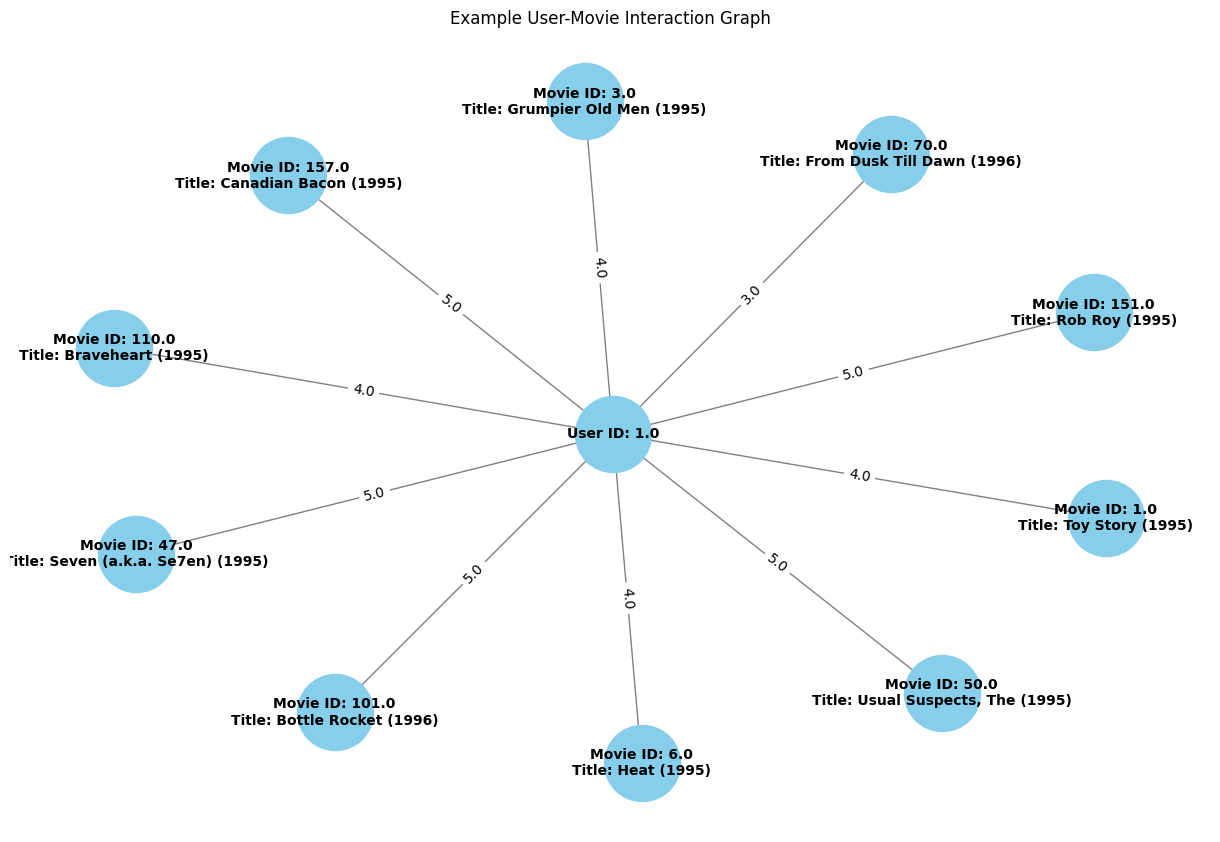

In [ ]:
import pandas as pd
import torch
import networkx as nx
import matplotlib.pyplot as plt

# Load the MovieLens data
movies_path = './ml-latest-small/movies.csv'
ratings_path = './ml-latest-small/ratings.csv'
movies_df = pd.read_csv(movies_path, index_col='movieId')
ratings_df = pd.read_csv(ratings_path)

# Select a subset of data for visualization
subset_ratings = ratings_df.head(10)  # Selecting the first 10 ratings for simplicity

# Create a NetworkX graph
G = nx.Graph()

# Add nodes for movies and users with metadata
for _, row in subset_ratings.iterrows():
    user_id = f"user_{int(row['userId'])}"
    movie_id = f"movie_{int(row['movieId'])}"
    movie_title = movies_df.loc[int(row['movieId'])]['title']

    # Add user node
    if not G.has_node(user_id):
        G.add_node(user_id, label=f"User ID: {row['userId']}")

    # Add movie node
    if not G.has_node(movie_id):
        G.add_node(movie_id, label=f"Movie ID: {row['movieId']}\nTitle: {movie_title}")

    # Add edge with rating as weight
    G.add_edge(user_id, movie_id, rating=row['rating'])

# Plot the graph
pos = nx.spring_layout(G)
labels = nx.get_node_attributes(G, 'label')
edge_labels = nx.get_edge_attributes(G, 'rating')

plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, labels=labels, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold", font_color="black", edge_color="gray")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Example User-Movie Interaction Graph")
plt.show()
